In [22]:
!pip install gymnasium torch matplotlib numpy
!pip install swig
!pip install "gymnasium[box2d]"


In [23]:
import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Lunar Lander problem

In [24]:
# Set seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

In [25]:
# Hyperparameters
GAMMA = 0.85
EPSILON = 0.2
EPISODES = 2500
BATCH_SIZE = 32
MEMORY_SIZE = 100000
LEARNING_RATE = 1e-3
TARGET_UPDATE = 10

In [19]:
# Neural Network for DQN
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

# Experience replay memory
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Select action using epsilon-greedy policy
def select_action(state, policy_net, epsilon, action_dim):
    if random.random() < epsilon:
        return random.randrange(action_dim)
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = policy_net(state_tensor)
            return q_values.argmax().item()

# Training step
def train(policy_net, target_net, memory, optimizer, batch_size, gamma):
    if len(memory) < batch_size:
        return 0
    batch = memory.sample(batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

    state_batch = torch.FloatTensor(state_batch)
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1)
    next_state_batch = torch.FloatTensor(next_state_batch)
    done_batch = torch.FloatTensor(done_batch).unsqueeze(1)

    current_q = policy_net(state_batch).gather(1, action_batch)
    next_q = target_net(next_state_batch).max(1)[0].detach().unsqueeze(1)
    target_q = reward_batch + gamma * next_q * (1 - done_batch)

    loss = nn.MSELoss()(current_q, target_q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [20]:
# Main training loop
env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayBuffer(REPLAY_MEMORY_SIZE)

episode_rewards = []
losses = []
mean_scores = []

for episode in range(1, NUM_EPISODES + 1):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = select_action(state, policy_net, EPSILON, action_dim)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        loss = train(policy_net, target_net, memory, optimizer, BATCH_SIZE, GAMMA)
        if loss is not None:
            losses.append(loss)

    episode_rewards.append(total_reward)

    # Update target network every 10 episodes
    if episode % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Logging
    if episode % 100 == 0:
        mean_score = np.mean(episode_rewards[-100:])
        mean_scores.append(mean_score)
        print(f"Episode {episode}, Mean Reward (last 100): {mean_score:.2f}")

env.close()

<ipython-input-19-2f8aa9990d05>:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  state_batch = torch.FloatTensor(state_batch)


Episode 100, Mean Reward (last 100): -133.13
Episode 200, Mean Reward (last 100): -39.31
Episode 300, Mean Reward (last 100): -38.40
Episode 400, Mean Reward (last 100): -49.89
Episode 500, Mean Reward (last 100): -59.00
Episode 600, Mean Reward (last 100): -60.86
Episode 700, Mean Reward (last 100): -67.34
Episode 800, Mean Reward (last 100): -52.79
Episode 900, Mean Reward (last 100): -46.11
Episode 1000, Mean Reward (last 100): -54.91
Episode 1100, Mean Reward (last 100): -62.92
Episode 1200, Mean Reward (last 100): -42.91
Episode 1300, Mean Reward (last 100): -51.29
Episode 1400, Mean Reward (last 100): -73.58
Episode 1500, Mean Reward (last 100): -70.64
Episode 1600, Mean Reward (last 100): -55.04
Episode 1700, Mean Reward (last 100): -42.94
Episode 1800, Mean Reward (last 100): -20.59
Episode 1900, Mean Reward (last 100): -48.39
Episode 2000, Mean Reward (last 100): -38.12
Episode 2100, Mean Reward (last 100): -41.80
Episode 2200, Mean Reward (last 100): -18.25
Episode 2300, Mean

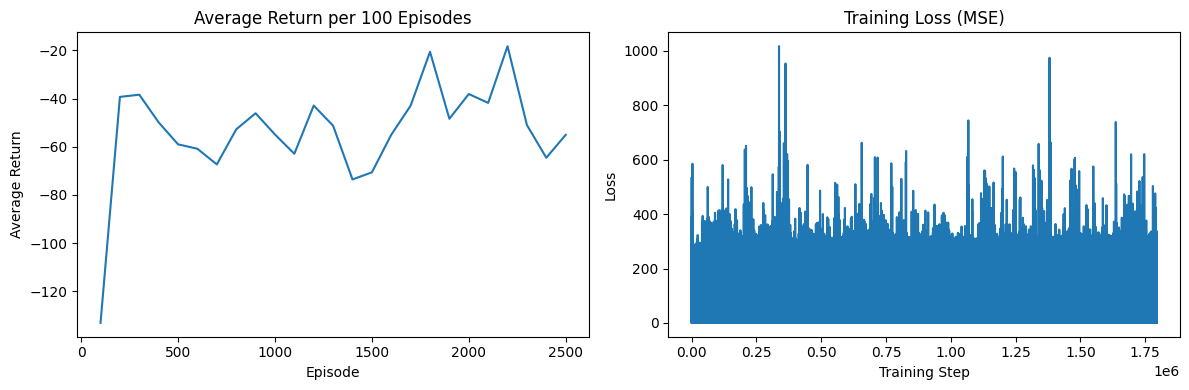

In [21]:
# Plot average return per 100 episodes
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(100, NUM_EPISODES + 1, 100), mean_scores)
plt.title('Average Return per 100 Episodes')
plt.xlabel('Episode')
plt.ylabel('Average Return')

# Plot MSE Loss
plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title('Training Loss (MSE)')
plt.xlabel('Training Step')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


# Acrobat v1 problem

In [26]:
# Set random seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [27]:
# Define DQN Network
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# Replay buffer
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Select action using epsilon-greedy policy
def select_action(state, policy_net, epsilon, action_space):
    if random.random() < epsilon:
        return random.randint(0, action_space - 1)
    with torch.no_grad():
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state)
        return q_values.argmax().item()

# Train the DQN
def optimize_model(memory, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return 0

    transitions = memory.sample(BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*transitions)

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards).unsqueeze(1)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones).unsqueeze(1)

    current_q_values = policy_net(states).gather(1, actions)
    next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
    expected_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

    loss = nn.MSELoss()(current_q_values, expected_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


In [28]:
# Main Training Loop
env = gym.make("Acrobot-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(MEMORY_SIZE)

returns = []
losses = []
mean_returns = []

for episode in range(EPISODES):
    state, _ = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = select_action(state, policy_net, EPSILON, action_dim)
        next_state, reward, done, _, _ = env.step(action)
        memory.push((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        loss = optimize_model(memory, policy_net, target_net, optimizer)
        if loss:
            losses.append(loss)

    returns.append(total_reward)

    if episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if episode % 100 == 0:
        avg_return = np.mean(returns[-100:])
        mean_returns.append(avg_return)
        print(f"Episode {episode}, Average Return (last 100): {avg_return}")

env.close()



Episode 0, Average Return (last 100): -4438.0
Episode 100, Average Return (last 100): -545.66
Episode 200, Average Return (last 100): -395.71
Episode 300, Average Return (last 100): -383.63
Episode 400, Average Return (last 100): -328.85
Episode 500, Average Return (last 100): -306.45
Episode 600, Average Return (last 100): -282.43
Episode 700, Average Return (last 100): -276.04
Episode 800, Average Return (last 100): -262.94
Episode 900, Average Return (last 100): -372.01
Episode 1000, Average Return (last 100): -315.58
Episode 1100, Average Return (last 100): -343.37
Episode 1200, Average Return (last 100): -352.71
Episode 1300, Average Return (last 100): -398.47
Episode 1400, Average Return (last 100): -469.86
Episode 1500, Average Return (last 100): -313.72
Episode 1600, Average Return (last 100): -360.18
Episode 1700, Average Return (last 100): -301.44
Episode 1800, Average Return (last 100): -317.78
Episode 1900, Average Return (last 100): -339.12
Episode 2000, Average Return (la

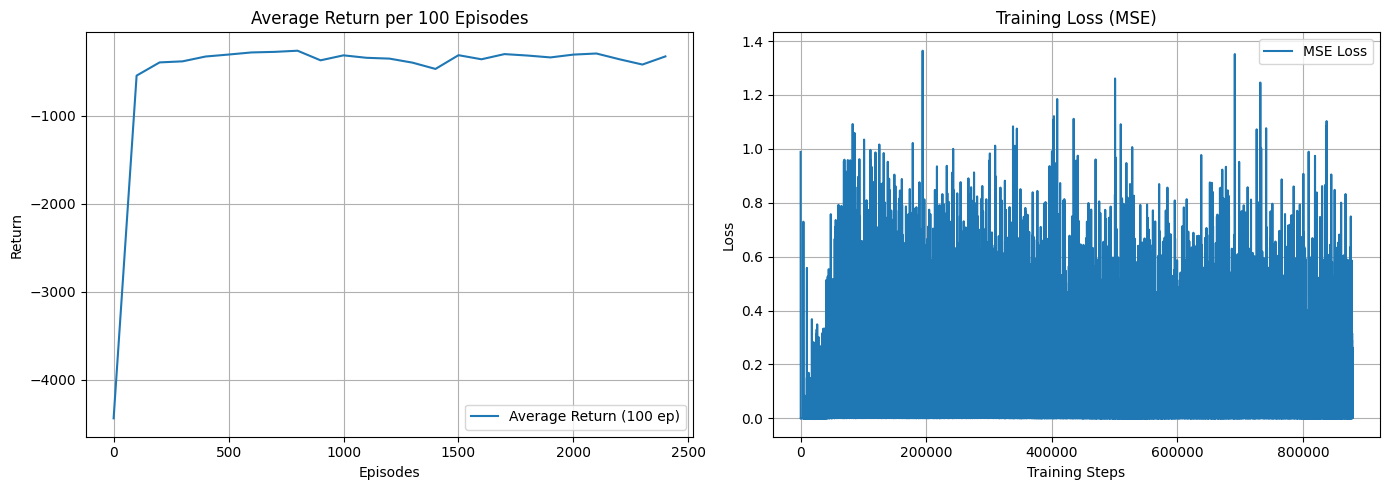

In [29]:
# Plotting
plt.figure(figsize=(14, 5))

# Returns
plt.subplot(1, 2, 1)
plt.plot(range(0, EPISODES, 100), mean_returns, label='Average Return (100 ep)')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Average Return per 100 Episodes')
plt.grid()
plt.legend()

# Losses
plt.subplot(1, 2, 2)
plt.plot(losses, label='MSE Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss (MSE)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()
